In [1]:
!pip install --upgrade --quiet datasets fsspec huggingface_hub numpy tensorflow pillow pandas

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image
import io
from datasets import Dataset, DatasetDict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
full_df = pd.read_csv('data/fer2013.csv')
full_df.rename(columns={'emotion': 'labels', 'pixels': 'img_bytes'}, inplace=True)

train_df = full_df[full_df['Usage'] == 'Training']
val_df = full_df[full_df['Usage'] == 'PublicTest']
test_df = full_df[full_df['Usage'] == 'PrivateTest'] 

train_dataset = Dataset.from_pandas(train_df[['img_bytes', 'labels']], preserve_index=False)
val_dataset = Dataset.from_pandas(val_df[['img_bytes', 'labels']], preserve_index=False)
test_dataset = Dataset.from_pandas(test_df[['img_bytes', 'labels']], preserve_index=False)

ds = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(ds)

DatasetDict({
    train: Dataset({
        features: ['img_bytes', 'labels'],
        num_rows: 28709
    })
    validation: Dataset({
        features: ['img_bytes', 'labels'],
        num_rows: 3589
    })
    test: Dataset({
        features: ['img_bytes', 'labels'],
        num_rows: 3589
    })
})


In [4]:
def prepare_data_from_ds(split):
    subset = ds[split]
    
    pixel_strings = subset['img_bytes']
    labels = subset['labels']
    
    images = []
    for s in pixel_strings:
        pixel_array = np.fromstring(s, dtype=int, sep=' ')
        image = pixel_array.reshape(48, 48)
        images.append(image)
        
    X = np.array(images, dtype='float32')
    
    X = X[..., np.newaxis]
    
    X /= 255.0
    
    y = to_categorical(labels, num_classes=7)
    
    return X, y

In [5]:
X_train, y_train = prepare_data_from_ds("train")
X_val, y_val = prepare_data_from_ds("validation")
X_test, y_test = prepare_data_from_ds("test")

print("Train data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (28709, 48, 48, 1) (28709, 7)
Validation data shape: (3589, 48, 48, 1) (3589, 7)
Test data shape: (3589, 48, 48, 1) (3589, 7)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,         
    width_shift_range=0.1,     
    height_shift_range=0.1,    
    horizontal_flip=True,      
    fill_mode='nearest'       
)

datagen.fit(X_train)

print("ImageDataGenerator was successfully built and ready.")

ImageDataGenerator was successfully built and ready.


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\Erfan-Mingli\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 620,935 (2.37 MB)

 Trainable params: 619,975 (2.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
epochs = 75  
batch_size = 64

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs
)

print("Model training completed successfully.")

Epoch 1/75


C:\Users\Erfan-Mingli\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.2534 - loss: 2.1139 - val_accuracy: 0.2012 - val_loss: 1.9981
Epoch 2/75
  1/448 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.3750 - loss: 1.7352

C:\Users\Erfan-Mingli\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3750 - loss: 1.7352 - val_accuracy: 0.2014 - val_loss: 1.9936
Epoch 3/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.3553 - loss: 1.6663 - val_accuracy: 0.4394 - val_loss: 1.4618
Epoch 4/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4844 - loss: 1.6095 - val_accuracy: 0.4327 - val_loss: 1.4693
Epoch 5/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.4189 - loss: 1.5040 - val_accuracy: 0.4146 - val_loss: 1.4761
Epoch 6/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4219 - loss: 1.3872 - val_accuracy: 0.4252 - val_loss: 1.4609
Epoch 7/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.4419 - loss: 1.4475 - val_accuracy: 0.5049 - val_loss: 1.3070
Epoch 8/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4219 - loss: 1.3758 - val_accuracy: 0.5018 - val_loss: 1.3159
Epoch 9/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.4674 - loss: 1.3915 - val_accuracy: 0.507

Evaluating the model on test data...
Test Loss: 1.0790
Test Accuracy: 0.5935
------------------------------
Drawing accuracy and error charts...


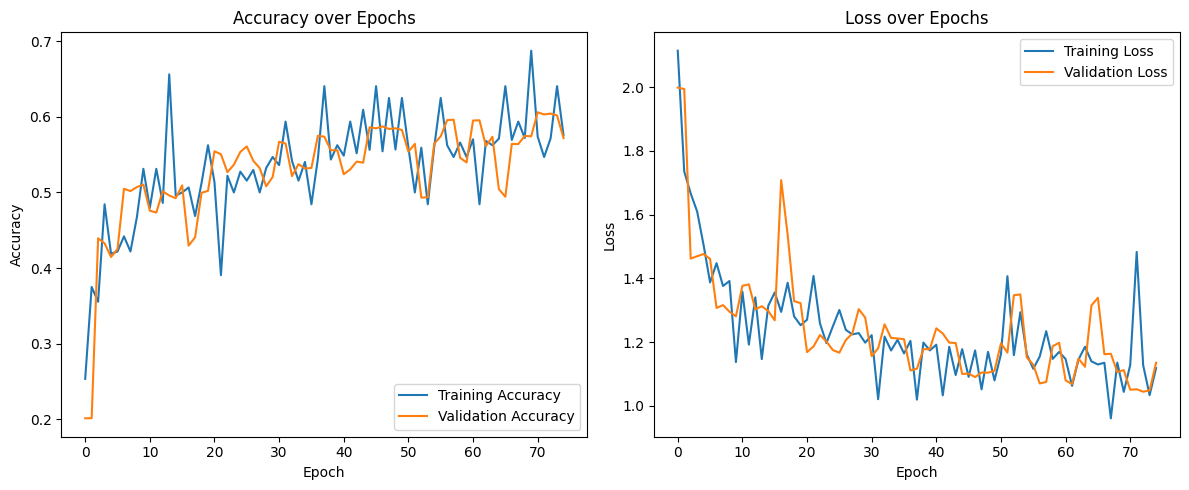

In [11]:
import matplotlib.pyplot as plt
print("Evaluating the model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("-" * 30)

print("Drawing accuracy and error charts...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() 
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


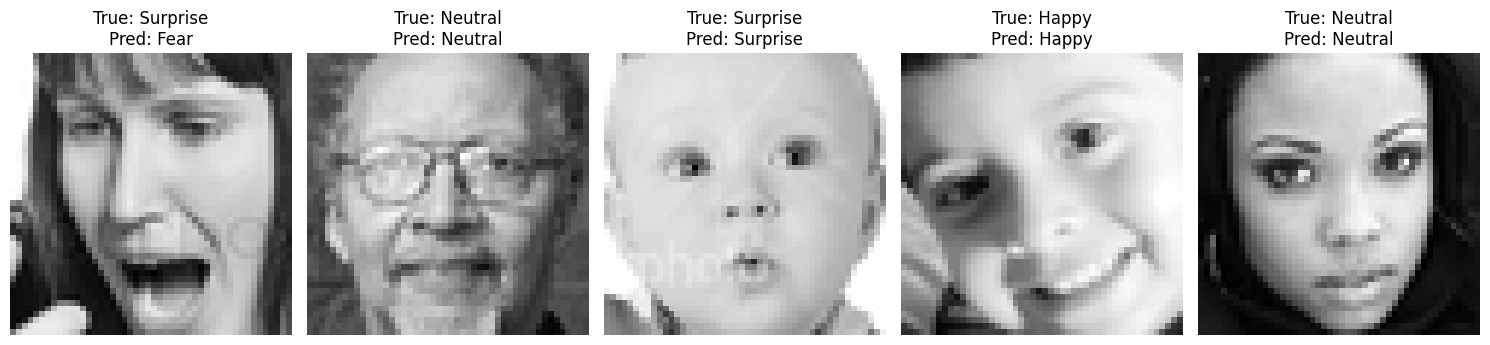

In [12]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

indices = np.random.choice(range(X_test.shape[0]), size=5, replace=False)

plt.figure(figsize=(15, 4))

for i, idx in enumerate(indices):
    img = X_test[idx].squeeze()
    true_label = emotion_labels[np.argmax(y_test[idx])]
    
    pred = model.predict(X_test[idx:idx+1])
    pred_label = emotion_labels[np.argmax(pred)]
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()